In [42]:
import pandas as pd
import scipy.stats as stats
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline


In [177]:
# Read in zones and bird-beak data.
zones = pd.read_csv('zones_group_bbh.csv')
zones = zones.set_index('pat_num')
zones

,zone,group,bbh,aortic zone,pat_id,group_numeric
pat_num,,,,,,
1,2,BBG,8.6,zone-2,T1,1
2,2,NBBG,3.3,zone-2,T2,0
3,2,NBBG,1.6,zone-2,T3,0
4,3,BBG,6.6,zone-3,T5,1
5,3,BBG,5.7,zone-3,T6,1
6,3,NBBG,1.4,zone-3,T7,0
7,4,BBG,9.3,zone-4,T9,1
8,3,NBBG,0.8,zone-3,T10,0
9,2,BBG,8.9,zone-2,T11,1


Stat: 117.0 P-Value: 0.012


count
group aortic zone       
BBG   zone-2        50.0
      zone-3        30.0
      zone-4        20.0
NBBG  zone-2        40.0
      zone-3        50.0
      zone-4        10.0

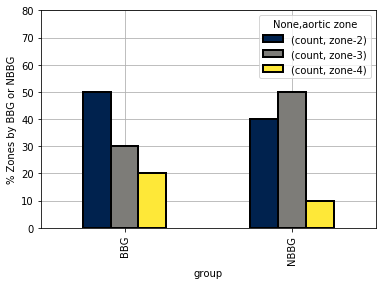

In [93]:
# Test
statistic, p = stats.mannwhitneyu(x=zones['zone'], y=zones['bbh'])
print("Stat: {} P-Value: {:.3f}".format(statistic, p))

# Group
zone_agg = zones.groupby('group').agg({'aortic zone': 'value_counts'}).sort_index().rename(columns={'aortic zone': 'count'})
zone_agg = zone_agg.groupby(level=0).apply(lambda x: 100 * x / float(x.sum()))
display(zone_agg)

# Plot
ax = zone_agg.unstack().plot(kind='bar', grid=True, colormap='cividis', edgecolor='k', linewidth=2)
ax.set_ylabel('% Zones by BBG or NBBG')
ax.set_ylim(0, 80)
ax.set_axisbelow(True)


/Users/maxfrohlich/anaconda3/lib/python3.7/site-packages/pandas/plotting/_core.py:185: UserWarning: 'colors' is being deprecated. Please use 'color'instead of 'colors'
  warnings.warn(("'colors' is being deprecated. Please use 'color'"


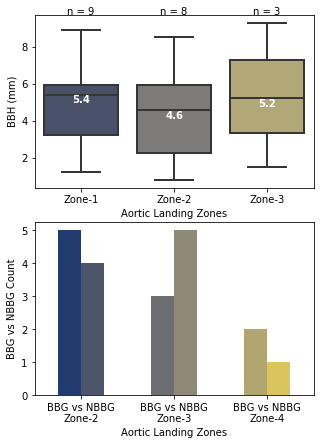

In [298]:

class ZonePlot:
    """
    Plot bird-beak height distribution by zone.
    
    Attributes:
    -----------
    data (pd.DataFrame)
        Contains bird-beak height and zone information.
    """
    def __init__(self, data):
        self.data = data
        self.plot_index = 0
    def _make_fig(self, nrows=1, ncols=1, figsize=(5,3)):
        """ Set up a figure"""
        #sns.set_palette("cividis", 3)
        self.fig, self.axes = plt.subplots(nrows,ncols,figsize=figsize)
        if (nrows * ncols) > 1:
            self.axes = self.axes.flatten()   
            self.ax = self.axes[self.plot_index]
        else:
            self.ax = self.axes
        self.nrows = nrows
        self.ncols = ncols
    def _next_ax(self):
        self.plot_index +=1
        self.ax = self.axes[self.plot_index]
    
    def box_plot(self, **kwargs):
        """ Box plot """          
        sns.boxplot(ax=self.ax, palette=sns.color_palette("cividis", 3), **kwargs)
        self.ax.set_ylabel('BBH (mm)')
        self.ax.set_xlabel('Aortic Landing Zones')
        self.ax.set_xticklabels(['Zone-1', 'Zone-2', 'Zone-3'])
        
    def swarm_plot(self, **kwargs):
        sns.swarmplot(**kwargs)
    

    
        
    def patch(self):
        """ Puts a patch in the background"""
        anchor_point = (-.5,5)
        length = 3
        height = 5
        alpha=0.1
        patch_shape = plt.Rectangle(anchor_point, length, height, alpha=alpha, color='r')
        self.ax.add_patch(patch_shape)
    def _agg_data(self):
        """ Aggregates patient data for annotation"""
        self.data_agg = self.data.groupby('aortic zone').agg({'bbh': ['count', 'median']})
        self.data_agg_counts = self.data.groupby('aortic zone').agg({'group': 'value_counts'}).sort_index().unstack()
    def annote_n(self):
        """ Annotate patient counts per each zone"""
        length_data = len(self.data_agg)
        row_ind = .5
        for _, row in self.data_agg.iterrows():
            n = row[('bbh','count')]
            plt.text(row_ind/length_data, 1,
                     s='n = {:.0f}'.format(n),
                     transform=self.ax.transAxes,
                     horizontalalignment='center')
            row_ind+=1
    def annote_median(self):
        """ Annotate the median value on each chart"""
        row_ind = 0
        for _, row in self.data_agg.iterrows():
            med = row[('bbh','median')]
            self.ax.annotate(xy=(row_ind, med),
                     s='{:.1f}'.format(med),
                     horizontalalignment='center',
                     verticalalignment='top',
                     color='w',
                     fontweight='bold')
            row_ind+=1
    def main_plot(self, save=None):
        self._agg_data()
        self._make_fig(2,1, (5,7))
        self.box_plot(x='aortic zone',y='bbh',data=self.data, linewidth=2)
        self.annote_n()
        self.annote_median()
        self._next_ax()
        self.barplot()
        #plt.tight_layout()
        #self.swarm_plot(x='aortic zone',y='bbh',data=self.data, color='r', marker='o', ax=self.ax)
        #self.patch()
        if save:
            plt.savefig(save, dpi=400, bbox_inches='tight')
            plt.show()
    
    def barplot(self, **kwargs):
        colors = sns.color_palette("cividis", 6)
        colors = [(colors[i], colors[i+2], colors[i+4]) for i in range(0, 2)]
        self.data_agg_counts.plot.bar(ax=self.ax, colors=colors, legend=False)
        self.ax.set_ylabel('BBG vs NBBG Count')
        self.ax.set_xlabel('Aortic Landing Zones')
        self.ax.set_xticklabels(['BBG vs NBBG\nZone-2','BBG vs NBBG\nZone-3', 'BBG vs NBBG\nZone-4'], rotation=0)
        
ZonePlot(zones).main_plot('zones_result_fig.png')

        